In [1]:
import import_ipynb
import baselines
import data_preparation

import kan

import torchvision
import torch
from torch import nn, optim
from torchsummary import summary
from torch.optim import lr_scheduler
from torchvision import models
from tqdm.notebook import tqdm, trange

from sklearn.metrics import roc_auc_score, precision_score, recall_score
import numpy as np

importing Jupyter notebook from baselines.ipynb
importing Jupyter notebook from data_preparation.ipynb
['а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я']


### Preparation

In [2]:
baselines.seed_torch()
device = data_preparation.device
device

'cuda'

In [3]:
# getting datasets
# english
class_names = data_preparation.class_names
img_datasets = data_preparation.img_datasets
dataloaders = data_preparation.dataloaders
dataset_sizes = data_preparation.dataset_sizes
class_names = data_preparation.class_names

In [4]:
# loading models and deleting classifier parts
# english
eng_model = torch.load('models/ENG_PROD.pth').features
eng_model.avgpool = nn.AdaptiveAvgPool2d(output_size=1)
eng_model.to(device)
None

In [ ]:
# creating new dataset for training KANs using MobileNet embeddings
new_dataset = {'train_input': [], 'test_input': [], 'train_label': [], 'test_label': []}
for phase in ['train', 'val']:
    pbar = tqdm(img_datasets[phase], leave=False, desc=f'{phase}')
    for data in pbar:
        features, label = data
        if phase == 'train':
            with torch.no_grad():
                embedding = eng_model(features.type(torch.FloatTensor).unsqueeze(0).to(device))
                new_dataset['train_input'].append(embedding.flatten().unsqueeze(0).to(device))
                new_dataset['train_label'].append(torch.tensor(label).to(device))
                torch.cuda.empty_cache()
        if phase == 'val':
            with torch.no_grad():
                embedding = eng_model(features.type(torch.FloatTensor).unsqueeze(0).to(device))
                new_dataset['test_input'].append(embedding.flatten().unsqueeze(0).to(device))
                new_dataset['test_label'].append(torch.tensor(label).to(device))
                torch.cuda.empty_cache()


In [ ]:
torch.cuda.empty_cache()

In [ ]:
new_dataset['train_input'] = torch.stack(new_dataset['train_input']).squeeze().to(device)
new_dataset['train_label'] = torch.stack(new_dataset['train_label']).to(device)
new_dataset['test_input'] = torch.stack(new_dataset['test_input']).squeeze().to(device)
new_dataset['test_label'] = torch.stack(new_dataset['test_label']).to(device)

In [ ]:
# creating KAN classifier
kan_classifier = kan.KAN(width=[960, 6, 26], grid=5, k=3, seed=0, device=device)
kan_classifier.Softmax = nn.Softmax(dim=-1)

In [ ]:
model_parameters = filter(lambda p: p.requires_grad, kan_classifier.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

In [ ]:
# creating metrics for train loop
def train_acc():
    return torch.mean((torch.argmax(kan_classifier(new_dataset['train_input']), dim=1) == new_dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(kan_classifier(new_dataset['test_input']), dim=1) == new_dataset['test_label']).float())

def train_roc_auc():
    return roc_auc_score(new_dataset['train_label'].numpy(), kan_classifier('train_input').numpy(), multi_class='ovo', labels=baselines.LABELS)

def test_roc_auc():
    return roc_auc_score(new_dataset['test_label'].numpy(), kan_classifier('test_input').numpy(), multi_class='ovo', labels=baselines.LABELS)

metrics = (train_acc, test_acc)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
results = kan_classifier.train(new_dataset, opt='LBFGS', steps=10, metrics=metrics, loss_fn=nn.CrossEntropyLoss(), device=device, batch=512, lr=1e-2)

In [ ]:
results

In [ ]:
sft = nn.Softmax(dim=-1)
probas = sft(kan_classifier(new_dataset['test_input']))
preds = torch.argmax(probas, -1).cpu().detach().numpy()
probas = probas.cpu().detach().numpy()
labels = new_dataset['test_label'].cpu().detach().numpy()
roc_auc = roc_auc_score(labels, probas, multi_class='ovo', labels=baselines.LABELS)
precision = precision_score(labels, np.argmax(preds), average='macro', labels=baselines.LABELS)
recall = recall_score(labels, preds, average='macro', labels=baselines.LABELS)
roc_auc, precision, recall

#### Results
During this phase several experiments on models shape were conducted. The results of these experiments are presented in the following table.
| width           | grid  |  k    | best accuracy | best epoch | numer of params |
| :-------------: | :---: | :---: | :-----------: | :--------: | :-------------: |
| [960, 1, 26]    | 7     | 5     | 0,37          | 5          | 17775           |
| [960, 1, 26]    | 10    | 5     | 0,34          | 5          | 20733           |
| [960, 1, 26]    | 15    | 5     | 0,34          | 5          | 25663           |
| [960, 1, 26]    | 7     | 10    | 0,37          | 5          | 22705           |
| [960, 1, 26]    | 25    | 5     | 0,28          | 4          | 35523           |
| [960, 5, 26]    | 3     | 3     | 0,83          | 8          | 59191           |
| [960, 6, 26]    | 3     | 3     | 0,87          | 9          | 71024           |
| [960, 7, 26]    | 3     | 3     | OUT OF TIME   | -          | 82857           |
| [960, 1, 1, 26] | 3     | 3     | 0,24          | 5          | 11872           |
| [960, 6, 4, 26] | 3     | 3     | OUT OF TIME   | -          | 70692           |

As the experiments show, increasing grid and k not always results in increasing a test accuracy. However, too high grid and k lead to ineffective increasing of total number of params. Some of the models, that have either too many params or layers take a lot of time to train even on a few epochs. The best model, that was created on this step of the development has reached the following results: test accuracy = 0.869, test roc-auc = 0.979, presicion = 0.98 and recall = 0.97.

### REGULARIZATION

In [5]:
def freeze_layers(model, num_layers):
    cnt = 0
    for child in model.children():
        if cnt < num_layers:
            for param in child.parameters():
                param.requires_grad = False
        cnt += 1
    mobile_v3 = model.cuda()
    
    return mobile_v3

In [6]:
eng_model = freeze_layers(eng_model, 14)
eng_model = eng_model.cuda()

In [7]:
class Classifier(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, grid, k, device='cuda'):
        super().__init__()

        self.first_layer = kan.KANLayer(in_dim=in_dim, out_dim=hid_dim, k=k, num=grid, device=device)
        self.norm = nn.BatchNorm1d(num_features=hid_dim)
        self.second_layer = kan.KANLayer(in_dim=hid_dim, out_dim=out_dim, k=k, num=grid, device=device)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        x = x.squeeze(2, 3)
        x = self.first_layer(x)[0]
        x = self.norm(x)
        x = self.second_layer(x)[0]
        x = self.softmax(x)
        return x

In [8]:
classifier = Classifier(960, 6, 26, 5, 2)
classifier = classifier.cuda()

In [9]:
eng_model.classifier = classifier
eng_model = eng_model.cuda()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(eng_model.parameters(), lr=1e-3)
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.15)
results = baselines.train(eng_model, loss_fn, optimizer, lr_scheduler, dataloaders, dataset_sizes, num_epochs=20, verbose=1)

In [ ]:
model, losses, accuracies, roc_aucs = results

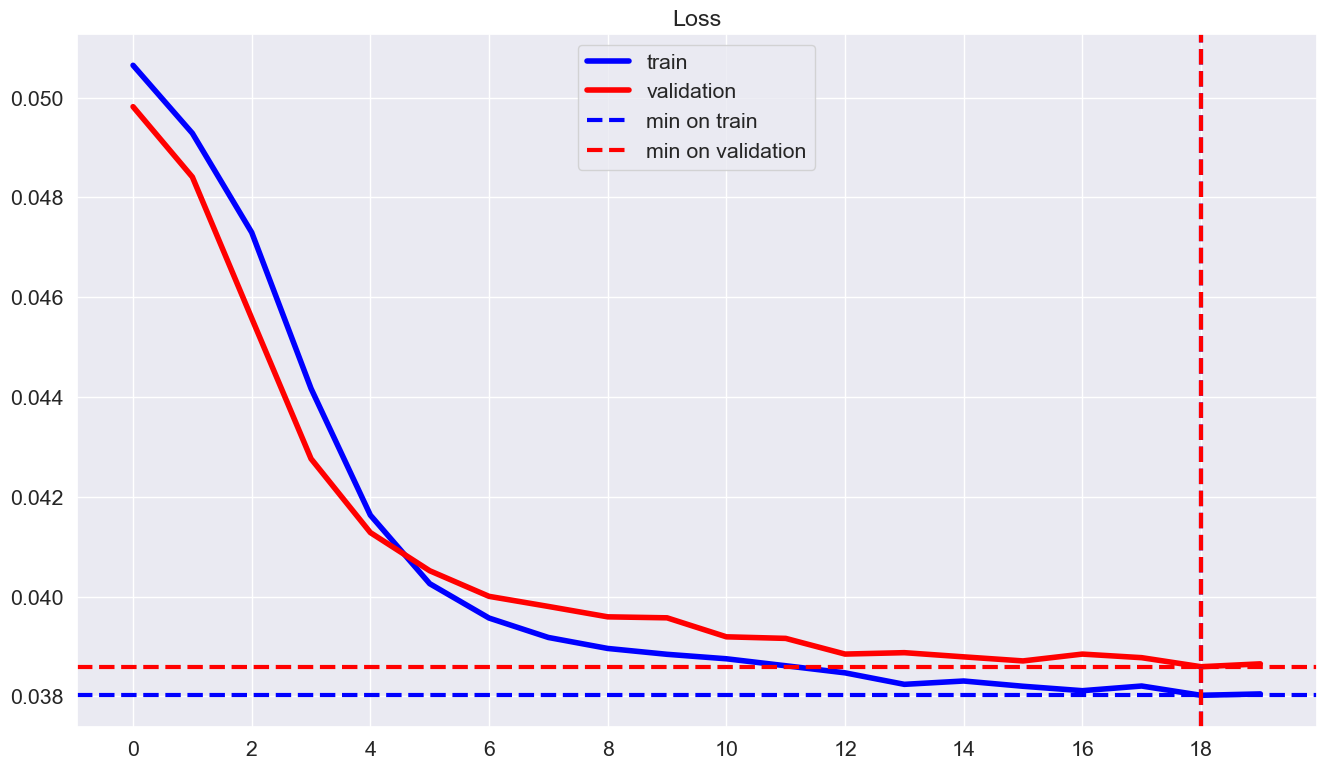

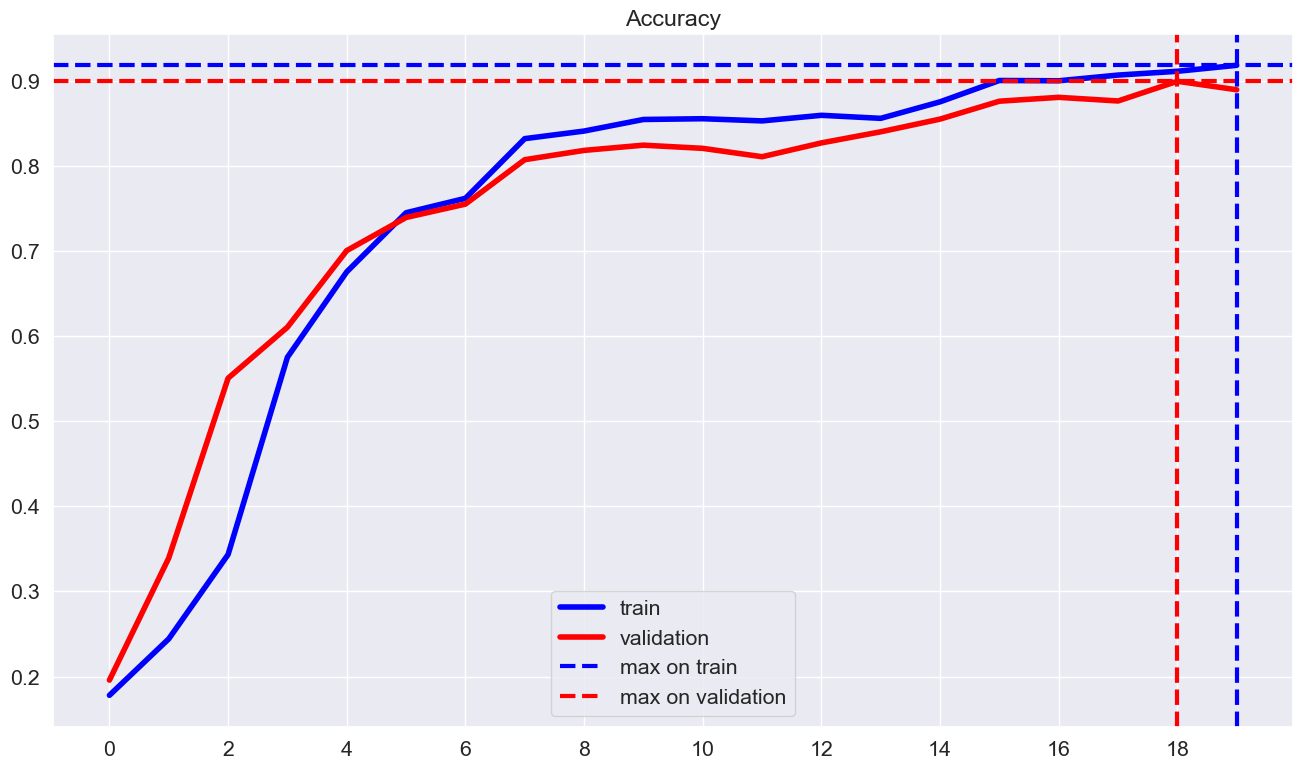

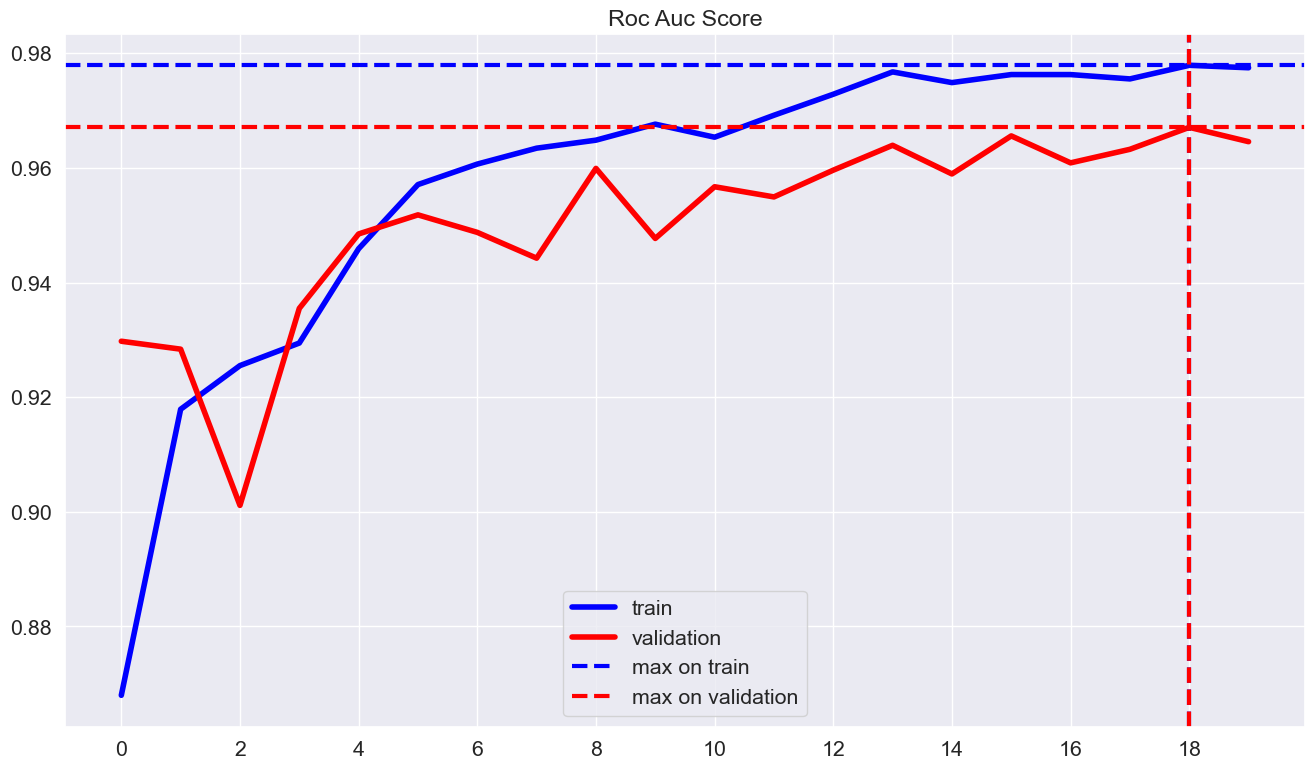

In [17]:
baselines.train_plot(losses, accuracies, roc_aucs)

#### Results
During this phase two main regularization techniques were tested on a KAN architecture. Also there were multiple changes in the inner part of the model (e.g. the base function, degree of the polynom in Bezier curve, number of knots for the B-spline were affected). The best results were shown by the models, that use batchnorm layers instead of dropout.
In the following table the results of some experiments can be found.
| width           | grid  |  k    | best accuracy | act fun | numer of params |
| :-------------: | :---: | :---: | :-----------: | :-----: | :-------------: |
| [960, 6, 26]    | 100   | 2     | 0,72          | SiLU    | 638960          |
| [960, 6, 26]    | 50    | 2     | 0,56          | SiLU    | 343160          |
| [960, 6, 26]    | 200   | 2     | 0,34          | SiLU    | 1230560         |
| [960, 6, 26]    | 20    | 2     | 0,85          | SiLU    | 165680          |
| [960, 6, 26]    | 5     | 2     | 0,90          | SiLU    | 76940           |
| [960, 6, 26]    | 5     | 3     | 0,87          | SiLU    | 82856           |
| [960, 6, 26]    | 5     | 2     | 0,86          | Sigmoid | 76940           |
| [960, 6, 26]    | 5     | 2     | 0,83          | Relu    | 76940           |
| [960, 6, 26]    | 5     | 2     | 0,85          | Tanh    | 76940           |

Here, *grid* is the number of  states for B-spline knots (meeting points of two Bezier curves), *k* is the degree of the polynom, *best acc* is the best accuracy shown on the val split, *act fun* - base activation function of the Bezier curves, *number of params* number of parameters in the classifier part before pruning.

As the experiments show, the best model has grid = 5, k = 2 and a SiLU activation function. The best achieved accuracy is approximately equal to 0.9. The final KAN model is almost 2x smaller than the MLP, and almost as accurate as it.